# Generating haplotypes for simulated populations.

In [2]:
import scipy
import numpy as np
from sklearn.decomposition import PCA
from scipy.stats import invgamma
from scipy.stats import beta
import matplotlib.pyplot as plt

import plotly
import plotly.plotly as py
import plotly.graph_objs as go
from plotly.offline import download_plotlyjs, init_notebook_mode, plot, iplot

init_notebook_mode(connected=True)

This is a very rough approach at generating haplotypes for two or more different populations.

For each population, alternative allele frequencies will be drawn randomly from the chosen distribution. 

Each individual will then have his haplotype drawn using the allele frequency vector pertaining to his population.

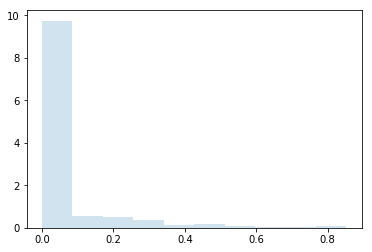

In [3]:
## the distribution i chose here was the beta distribution.
# doc: https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.beta.html#scipy.stats.beta

# This is because with the right parameters a and b, the probability density produced 
# resembles that often seen in allele frequency densities.
# let's see what that looks like:

a, b = 1.8, .1
r= beta.rvs(a, b, size=1000)
r= [1-x for x in r] 

fig, ax = plt.subplots(1, 1) 
ax.hist(r, normed=True, histtype='stepfilled', alpha=0.2)
plt.show()

In [4]:
# a= 1.8 and b= .1 seem appropriate, lets proceed to create our populations

# We must first define the number of populations, the length of the haplotypes desired, and their respective population sizes:
N_pops= 4
L= 200
Sizes= [250,100,300,150]
labels= np.repeat(np.array([x for x in range(N_pops)]),Sizes)

data= []

for k in range(N_pops):
    
    probs= beta.rvs(a, b, size=L)
    probs[(probs > 1)]= 1
    
    m= Sizes[k]
    Haps= [[np.random.choice([1,0],p= [1-probs[x],probs[x]]) for x in range(L)] for acc in range(m)]
    
    data.extend(Haps)

data= np.array(data)
print(data.shape)

(800, 200)


In [5]:
n_comp = 3

pca = PCA(n_components=n_comp, whiten=False,svd_solver='randomized')
features = pca.fit_transform(data)

print("; ".join(['PC{0}: {1}'.format(x+1,round(pca.explained_variance_ratio_[x],3)) for x in range(n_comp)]))
print(features.shape)

PC1: 0.143; PC2: 0.099; PC3: 0.076
(800, 3)


In [6]:
## lets visualize the result now:

fig_data= [go.Scatter3d(
        x = features[[x for x in range(sum(Sizes)) if labels[x] == i],0],
        y = features[[x for x in range(sum(Sizes)) if labels[x] == i],1],
        z = features[[x for x in range(sum(Sizes)) if labels[x] == i],2],
        type='scatter3d',
        mode= "markers",
        marker= {
        'line': {'width': 0},
        'size': 4,
        'symbol': 'circle',
      "opacity": .8
      },
      name= str(i)
    ) for i in range(N_pops)]


layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=fig_data, layout=layout)
iplot(fig)


This looks very nice. Frequencies drawn at random from a predetermined beta distribution produce very different vectors, which translate into neatly separated populations. 

Here, the degree of differentiation between our populations will be proportional to the correlation between the vectors we created them with. However, by drawing at random from a single beta distribution, we really have no hand over the relative distances between these vectors.

How can we simulate populations, or vectors, in a way that allows us to have at least some control over their relative differences? 

Population genetics models could provide us with an answer, by assuming mutation rates, growth rates, recombination and standard age gaps to coalesce our four populations and extract ancestral vectors and sizes at nodes of our choosing.


- If we don't need the information generated in that process however, a more pragmatic approach is possible.

Since what we are looking to do is identify a degree of correlation between these vectors before we generate their associated haplotypes, it stands that a PCA should do the job. 

In the first part, we drew four vectors only for stable values of _a_ and _b_, the beta parameters. Let's make those parameters vary, and draw 10 vectors at each change.

In [15]:

# We must first define the number of populations, the length of the haplotypes desired, and their respective population sizes
L= 300

import itertools as it
n= 10
a_range= np.linspace(1,2,11)
a_set= [i for i in a_range for _ in range(n)]

b_range= np.linspace(0.1,.4,11)
b_set= [i for i in b_range for _ in range(n)]

L_set= [L] * n * 11

traces= [x for x in it.product(range(n*11),range(n*11),range(n*11))]

background= np.array([a_set,b_set,L_set]).T

vector_lib= []
for k in range(background.shape[0]):
    
    probs= beta.rvs(background[k,0], background[k,1], size=int(background[k,2]))
    probs[(probs > 1)]= 1
    
    
    vector_lib.append(probs)

vector_lib= np.array(vector_lib)



And reduce their dimension through PCA.

In [16]:
n_comp = 3

pca = PCA(n_components=n_comp, whiten=False,svd_solver='randomized')
features = pca.fit_transform(vector_lib)

print("; ".join(['PC{0}: {1}'.format(x+1,round(pca.explained_variance_ratio_[x],3)) for x in range(n_comp)]))
print('features shape: {}'.format(features.shape))

PC1: 0.027; PC2: 0.023; PC3: 0.022
features shape: (110, 3)


In [17]:

fig_data= [go.Scatter3d(
        x = features[:,0],
        y = features[:,1],
        z = features[:,2],
        type='scatter3d',
        mode= "markers",
        text= ['a: {}; b: {}, L: {}; index = {}'.format(background[k,0],background[k,1],background[k,2], k) for k in range(background.shape[0])],
        marker= {
        'line': {'width': 0},
        'size': 4,
        'symbol': 'circle',
      "opacity": .8
      }
    )]


layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=fig_data, layout=layout)
iplot(fig)


Principal component analysis of the vectors produced. Their index along the vector_lib array can be examined by hovering above the points,

Their distances in this space are our indicators of correlation among these vectors. Chose them according to the scenarios intended and generate the haplotypes. Below i chose four, and plotted the result of a PCA on the resulting data set. I won't comment on them, the process is random, and so will be the relationships betweem the populations.


In [18]:
Pops= [3,15,1,30,75]
N_pops= len(Pops)
L= 200
Sizes= [50,50,50,50,50]
labels= np.repeat(np.array([x for x in range(N_pops)]),Sizes)

data= []

for k in range(N_pops):
    
    probs= vector_lib[Pops[k],:]
    
    m= Sizes[k]
    Haps= [[np.random.choice([1,0],p= [1-probs[x],probs[x]]) for x in range(L)] for acc in range(m)]
    
    data.extend(Haps)

data= np.array(data)
print(data.shape)

(250, 200)


In [19]:
n_comp = 4

pca = PCA(n_components=n_comp, whiten=False,svd_solver='randomized')

features= pca.fit_transform(data)


print("; ".join(['PC{0}: {1}'.format(x+1,round(pca.explained_variance_ratio_[x],3)) for x in range(n_comp)]))
print(features.shape)

PC1: 0.132; PC2: 0.109; PC3: 0.097; PC4: 0.082
(250, 4)


In [20]:
## lets visualize the result now:

fig_data= [go.Scatter3d(
        x = features[[x for x in range(sum(Sizes)) if labels[x] == i],0],
        y = features[[x for x in range(sum(Sizes)) if labels[x] == i],1],
        z = features[[x for x in range(sum(Sizes)) if labels[x] == i],2],
        type='scatter3d',
        mode= "markers",
        marker= {
        'line': {'width': 0},
        'size': 4,
        'symbol': 'circle',
      "opacity": .8
      },
      name= str(i)
    ) for i in range(N_pops)]


layout = go.Layout(
    margin=dict(
        l=0,
        r=0,
        b=0,
        t=0
    )
)

fig = go.Figure(data=fig_data, layout=layout)
iplot(fig)
